<a href="https://colab.research.google.com/github/tiitvaino/NAI22_hand_drawn_sketches/blob/main/load_preprocesss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing data
In this note book sketches are transformed to 100x100 grayscale images, where pixel values are in the range of 0 to 1 and if this sketch was recognized or not.
Data is saved to directories /norm_imgs/ and /recognized/, where each file name represents class name.

### Imports

In [1]:
import json
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from IPython.display import display
import cv2

import warnings
warnings.filterwarnings('ignore')

### Getting data

Data is imported from google cloud.
In windows run in external terminal: gcloud init --console-only

In [12]:
# loading sketches 
# NOTE: it will load a lot of data
!gsutil -mq cp "gs://quickdraw_dataset/full/simplified/*.ndjson" ./raw_data

# Main classes
#!gsutil -mq cp "gs://quickdraw_dataset/full/simplified/keyboard.ndjson" ./raw_data
#!gsutil -mq cp "gs://quickdraw_dataset/full/simplified/monkey.ndjson" ./raw_data
#!gsutil -mq cp "gs://quickdraw_dataset/full/simplified/fish.ndjson" ./raw_data

### Read data in

In [65]:
def read_sketch_data(file_name:str, max_lines_to_read:int=None, max_nr_elements:int=None, good_only:bool=True)->pd.DataFrame:
  """
  Read from info about one class of sketches data.
  If max_nr_elements==None then all info is read.
  If good_only==False then all sketces info is saved.
  """
  print(f'Reading sketches from {file_name}')
  df = pd.DataFrame(columns= ['word', 'countrycode', 'timestamp', 'recognized', 'key_id', 'drawing'])
  nr_elements = 0
  with open(file_name) as f:
    for row in f.readlines():
      data = json.loads(row)
      df_row = pd.DataFrame.from_dict(data,orient='index').T
      if not df_row['recognized'].iloc[0]:
        continue
      df = df.append([df_row])
      if max_lines_to_read != None:
        nr_elements+=1
        if max_lines_to_read <= nr_elements:
          break
  # get only good pictures
  if good_only:
    df = df[df.recognized == True]

  return df.sample(frac = 1)[:max_nr_elements if max_nr_elements else len(df)]

def read_sketches_data(data_files:list=None, max_lines_to_read:int=None, max_nr_imgs_per_cls:int=None, good_only:bool=True)->pd.DataFrame:
  """"
  Read every desired class info into one dataframe.
  """

  dataframes_dict = dict()
  for class_name in data_files:
    df_sketches = pd.DataFrame(columns= ['word', 'countrycode', 'timestamp', 'recognized', 'key_id', 'drawing'])
    df_sketches = df_sketches.append([read_sketch_data(class_name, max_lines_to_read, max_nr_imgs_per_cls,good_only)])
    word = df_sketches.word.iloc[0]
    dataframes_dict[word]=df_sketches
  
  return dataframes_dict

### Convert strokes to 100x100 images

In [57]:
def vector_to_img(vector)->np.array:
  def resize_point(x,y,size_from_original)->tuple:
    return round(x*size_from_original),round(y*size_from_original)

  stroke_locs =  [list(zip(stroke[0],stroke[1]))for stroke in vector]
  image = np.full((100,100),255,dtype=np.uint8)
  for stroke in stroke_locs:
    last_point = resize_point(int(stroke[0][0]),int(stroke[0][1]),0.25)
    for x,y in stroke:
      new_point = resize_point(int(x),int(y),0.25)
      cv2.line(image, last_point, new_point, 0, 2)
      last_point = new_point
  return image

def visualise_sketch(image):
  display(Image.fromarray(image))

def visualise_representative_sketches(dataframes_dict:dict):
  for class_name, df_class in dataframes_dict.items():
    print(class_name)
    visualise_sketch(vector_to_img(df_class[df_class['recognized']==True]['drawing'].iloc[0]))

### Normalise images

In [58]:
def preprocess_class(df:pd.DataFrame)->tuple:
  norm_imgs = np.asarray(df.apply(lambda row: vector_to_img(row['drawing'])/255.0,axis=1).to_numpy())
  recs = df['recognized'].to_numpy()

  preprocessed_df = pd.DataFrame({'recognized':recs,'norm_image':norm_imgs})

  return preprocessed_df

def preprocess_all_classes(dataframes_dict:dict)->dict:
  preprocessed_df_dict = {}
  for class_name,df_class in dataframes_dict.items():
    preprocessed_df = preprocess_class(df_class)
    preprocessed_df_dict[class_name] = preprocessed_df
  
  return preprocessed_df_dict

### Save preprocessed data into separated directories

In [59]:
def save_class_sketches(path:str,class_name:str,df_pre_class:pd.DataFrame):
  norm_imgs,recs = df_pre_class['norm_image'].to_numpy(),df_pre_class['recognized'].to_numpy()
  np.save(f'{path}/norm_imgs/{class_name}.npy',norm_imgs)
  np.save(f'{path}/recognized/{class_name}.npy',recs)

def create_dir(path:str):
  if not os.path.isdir(path):
    os.makedirs(path)

def save_all_classes(pre_dataframes_dict:dict,path:str='.'):
  create_dir(path)
  create_dir(f'{path}/norm_imgs')
  create_dir(f'{path}/recognized')

  for class_name,df_class in pre_dataframes_dict.items():
    save_class_sketches(path,class_name,df_class)
  
  np.save(f'{path}/processed_classes.npy',list(pre_dataframes_dict.keys()))

### Read data back in

In [60]:
def read_class_sketches(path:str,class_name:str)->pd.DataFrame:
  norm_imgs = np.load(f'{path}/norm_imgs/{class_name}.npy',allow_pickle=True)
  recs = np.load(f'{path}/recognized/{class_name}.npy',allow_pickle=True)
  preprocessed_df = pd.DataFrame({'recognized':recs,'norm_image':norm_imgs})
  return preprocessed_df

def read_all_classes(path:str='.')->pd.DataFrame:
  classes = np.load(f'{path}/processed_classes.npy')
  df_list = []
  for class_name in classes:
    preprocessed_df = read_class_sketches(path,class_name)
    preprocessed_df['word'] = class_name
    df_list.append(preprocessed_df)
  
  pre_df = pd.concat(df_list)
  pre_df['onehot'] = pre_df.word.str.get_dummies().values.tolist()

  return pre_df,classes

### Run everything and print out representatives sketches for some context

In [70]:
def main():
  # 10000 pictures takes approximately 10 s
  imgs_per_main_class = 1000
  imgs_per_noise_class = 100
  main_classes = ['keyboard','monkey','fish']
  main_classes = [f'{class_name}.ndjson' for class_name in main_classes]
  dir_name = './raw_data'

  # import main classes
  main_data_files = list(filter(lambda x: ('.ndjson' in x) and (x in main_classes), os.listdir(dir_name)))
  main_data_files = [f'{dir_name}/{file_name}' for file_name in main_data_files]
  print(main_data_files)
  main_dict_df_raws = read_sketches_data(main_data_files,20000,imgs_per_main_class,True) # Choose only good sketches for training
  main_dict_df_pres = preprocess_all_classes(main_dict_df_raws)
  save_all_classes(main_dict_df_pres,'./main_norm_imgs')
  visualise_representative_sketches(main_dict_df_raws)
  
  # import noise classes
  noise_data_files = list(filter(lambda x:  ('.ndjson' in x) and (x not in main_classes), os.listdir(dir_name)))
  noise_data_files = [f'{dir_name}/{file_name}' for file_name in noise_data_files]
  noise_dict_df_raws = read_sketches_data(noise_data_files,1000,imgs_per_noise_class,False) # Choose also bad sketches 

  noise_dict_df_pres = preprocess_all_classes(noise_dict_df_raws)
  save_all_classes(noise_dict_df_pres,'noise_norm_imgs')

['./raw_data/fish.ndjson', './raw_data/keyboard.ndjson', './raw_data/monkey.ndjson']
Reading sketches from ./raw_data/fish.ndjson
Reading sketches from ./raw_data/keyboard.ndjson
Reading sketches from ./raw_data/monkey.ndjson
fish


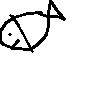

keyboard


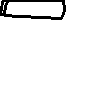

monkey


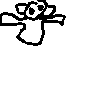

Reading sketches from ./raw_data/aircraft carrier.ndjson
Reading sketches from ./raw_data/airplane.ndjson
Reading sketches from ./raw_data/alarm clock.ndjson
Reading sketches from ./raw_data/ambulance.ndjson
Reading sketches from ./raw_data/angel.ndjson
Reading sketches from ./raw_data/animal migration.ndjson
Reading sketches from ./raw_data/ant.ndjson
Reading sketches from ./raw_data/anvil.ndjson
Reading sketches from ./raw_data/apple.ndjson
Reading sketches from ./raw_data/arm.ndjson
Reading sketches from ./raw_data/asparagus.ndjson
Reading sketches from ./raw_data/axe.ndjson
Reading sketches from ./raw_data/backpack.ndjson
Reading sketches from ./raw_data/banana.ndjson
Reading sketches from ./raw_data/bandage.ndjson
Reading sketches from ./raw_data/barn.ndjson
Reading sketches from ./raw_data/baseball bat.ndjson
Reading sketches from ./raw_data/baseball.ndjson
Reading sketches from ./raw_data/basket.ndjson
Reading sketches from ./raw_data/basketball.ndjson
Reading sketches from ./ra

In [71]:
main()